## Импорт библиотек и загрузка данных

In [1]:
# Установка библиотек

!pip install streamlit -q

In [2]:
# Импорт библиотек

import joblib
import numpy as np
import pandas as pd
from math import sqrt
import streamlit as st
from joblib import dump
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

Скачиваем необходимые данные с Google Drive

In [3]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=12UNNxWzKJ0RmQxaQp3acMHvXl7pKWv-N' -O main_data.csv -q

In [4]:
# Загрузка данных

df = pd.read_csv('main_data.csv')

df.head()

,region,address,price,total_area,kitchen_area,living_area,rooms_count,floor,floors_number,build_date,...,longitude,latitude,passenger_elevator,cargo_elevator,metro,metro_distance,metro_transport,district,is_apartments,is_auction
0,msk,"Москва, Большой Толмачёвский переулок",1996610000,459.4,81.4,173.3,5.0,7,8,NaN,...,37.620949,55.739757,1.0,1.0,"Полянка,Новокузнецкая,Третьяковская","6,10,4","walk,walk,transport","Якиманка,ЦАО",0.0,0
1,msk,"Москва, Самотечная ул., 5",66970000,160.0,25.0,119.0,3.0,3,9,1892.0,...,37.618318,55.775165,1.0,1.0,"Цветной бульвар,Достоевская,Сухаревская","6,9,13","walk,walk,walk","Тверской,ЦАО",NaN,1
2,msk,"Москва, Ильинка",378820000,157.4,41.1,50.7,3.0,3,5,NaN,...,37.623649,55.755140,NaN,NaN,"Площадь Революции,Театральная","3,6","walk,walk","Тверской,ЦАО",0.0,0
3,msk,"Москва, М. Бронная ул., 32",110500000,110.5,15.0,61.0,3.0,2,6,1912.0,...,37.593524,55.764197,1.0,0.0,"Маяковская,Пушкинская,Тверская","10,10,10","walk,walk,walk","Пресненский,ЦАО",NaN,1
4,msk,"Москва, Ильинка",1031300000,271.8,57.1,123.8,5.0,5,5,NaN,...,37.623509,55.755201,NaN,NaN,"Площадь Революции,Театральная","3,6","walk,walk","Тверской,ЦАО",0.0,0


## Анализ данных

In [5]:
# Размер датафрейма

df.shape

(5978, 26)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              5978 non-null   object 
 1   address             5978 non-null   object 
 2   price               5978 non-null   int64  
 3   total_area          5978 non-null   float64
 4   kitchen_area        3702 non-null   float64
 5   living_area         3834 non-null   float64
 6   rooms_count         5248 non-null   float64
 7   floor               5978 non-null   int64  
 8   floors_number       5978 non-null   int64  
 9   build_date          1497 non-null   float64
 10  isСomplete          3797 non-null   float64
 11  complitation_year   3869 non-null   float64
 12  house_material      5371 non-null   object 
 13  parking             1432 non-null   object 
 14  decoration          1222 non-null   object 
 15  balcony             1405 non-null   float64
 16  longit

In [7]:
# Явные дубликаты

df.duplicated().sum()

0

In [8]:
# Количество пропущенных значений

sorted(df.isna().sum().items(), key=lambda x: x[1])

[('region', 0),
 ('address', 0),
 ('price', 0),
 ('total_area', 0),
 ('floor', 0),
 ('floors_number', 0),
 ('longitude', 0),
 ('latitude', 0),
 ('is_auction', 0),
 ('district', 17),
 ('house_material', 607),
 ('rooms_count', 730),
 ('metro', 874),
 ('metro_distance', 874),
 ('metro_transport', 874),
 ('is_apartments', 938),
 ('complitation_year', 2109),
 ('living_area', 2144),
 ('isСomplete', 2181),
 ('kitchen_area', 2276),
 ('passenger_elevator', 2724),
 ('cargo_elevator', 3285),
 ('build_date', 4481),
 ('parking', 4546),
 ('balcony', 4573),
 ('decoration', 4756)]

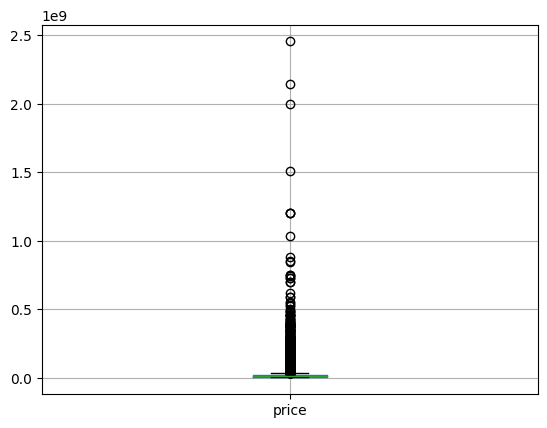

In [9]:
# Изучим целевую переменную

df.boxplot('price');

In [10]:
# Обрежем выбросы - оставим только те значения, что попадают в квантиль 0.95

df = df[df.price < df.price.quantile(q=0.90)]
df.shape

(5380, 26)

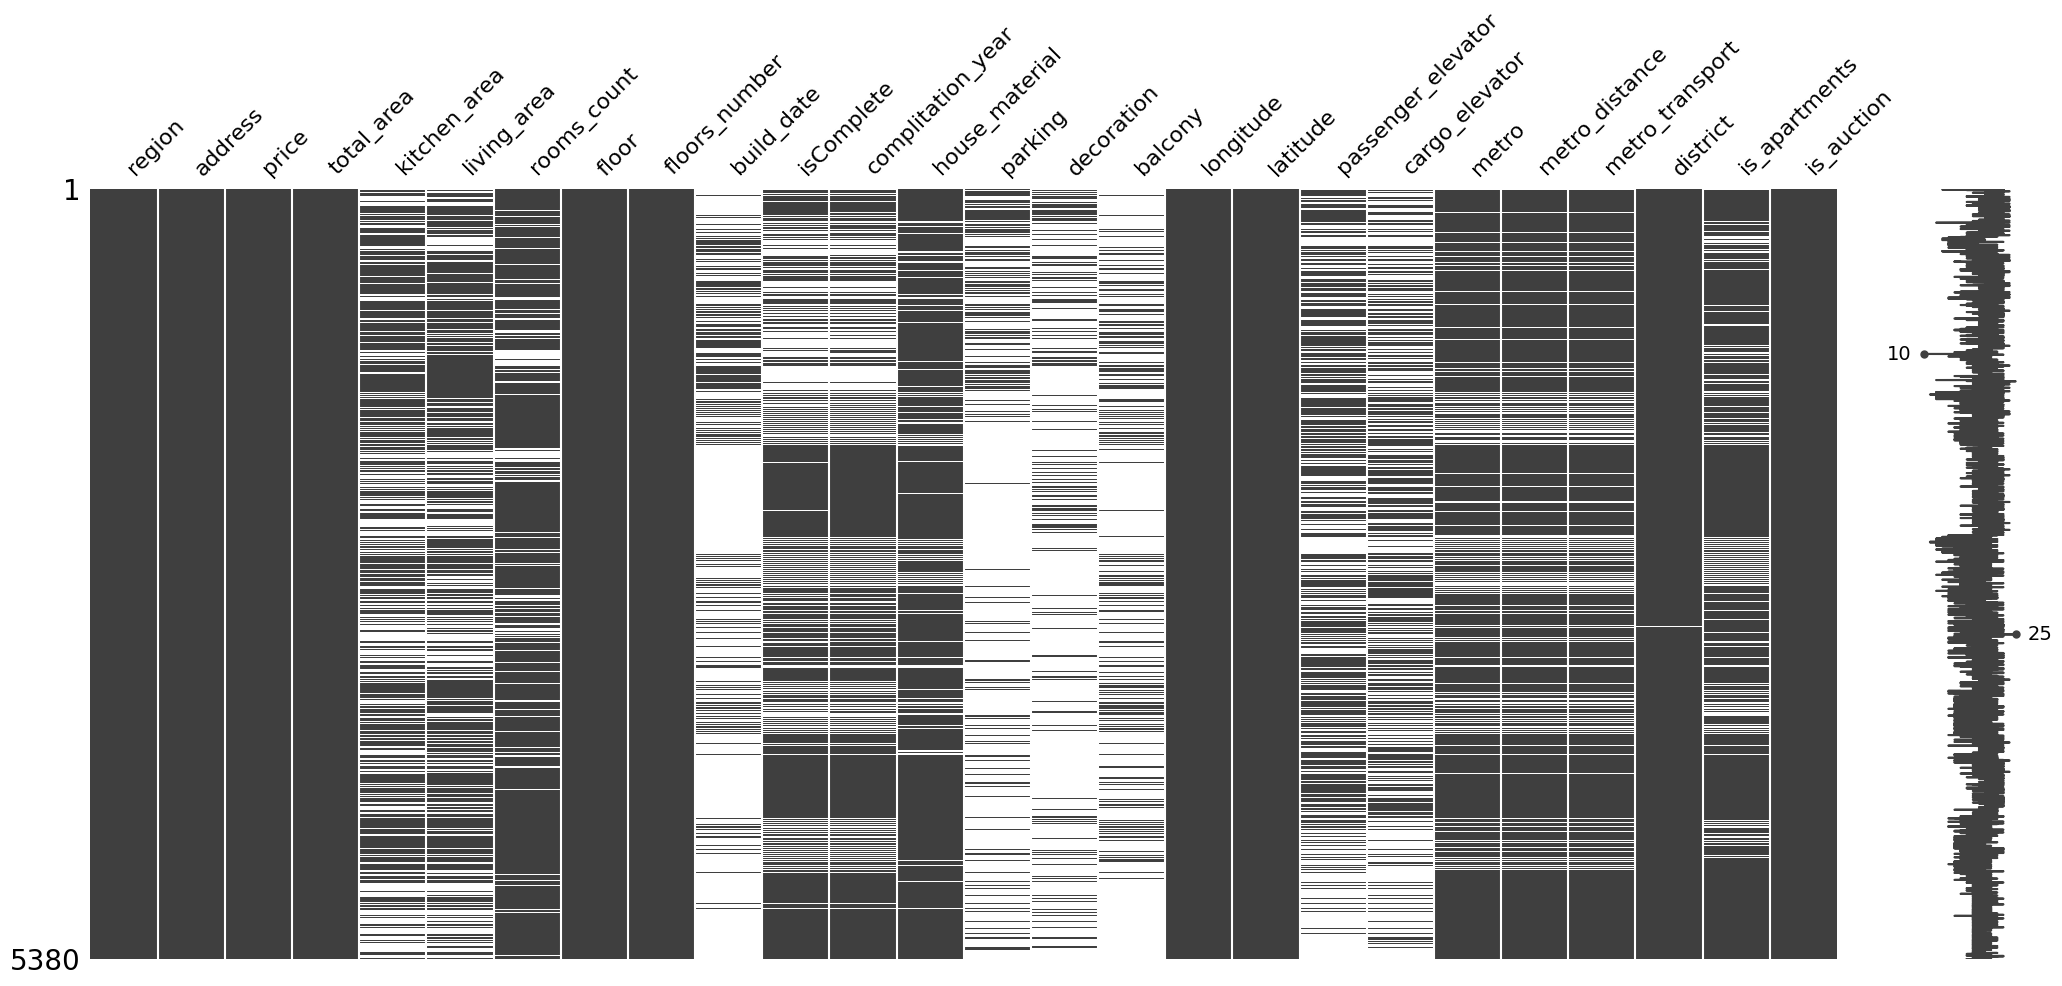

In [11]:
msno.matrix(df)
plt.show()

<ipython-input-12-10b83f3518e0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


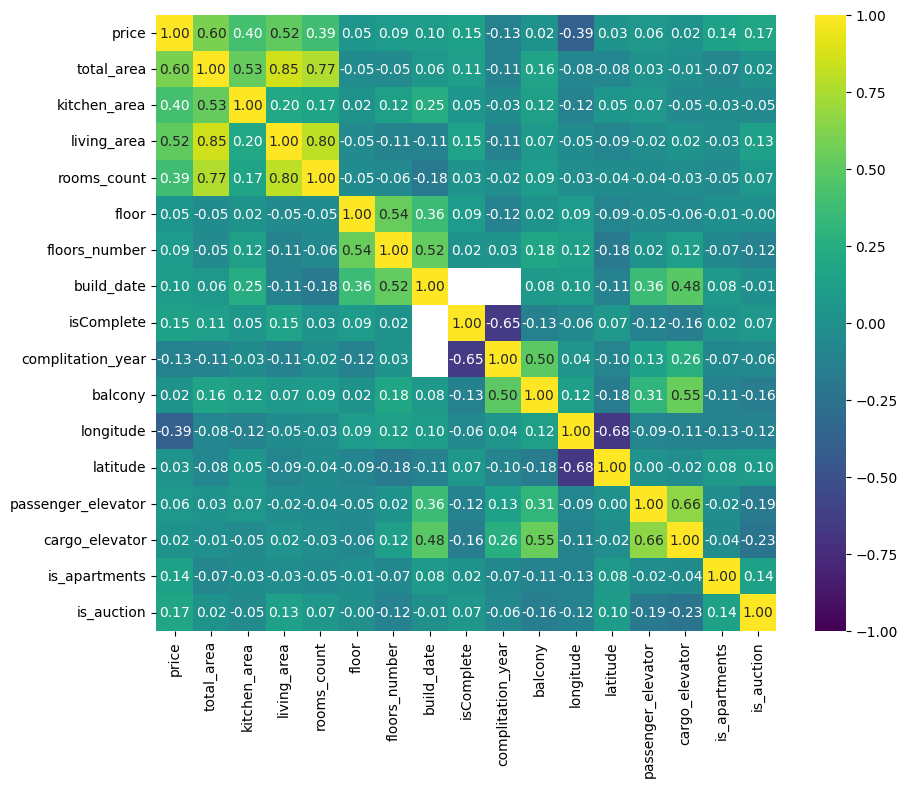

In [12]:
# Вычисление корреляционной матрицы

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f")
plt.show()

In [13]:
# Создание столбца "construction_year" из "build_date" или "complitation_year" и удаление старых столбцов

df['construction_year'] = df['build_date'].combine_first(df['complitation_year'])
df = df.drop(['build_date', 'complitation_year'], axis=1)

In [14]:
# Заполнение пропущенных значений в столбце 'isСomplete' на основе значений в столбце 'construction_year'

df['isСomplete'] = df.apply(lambda row: 0 if pd.isnull(row['isСomplete']) and row['construction_year'] > 2024 else
                                    1 if pd.isnull(row['isСomplete']) and row['construction_year'] < 2024 else
                                    row['isСomplete'], axis=1)

In [15]:
print("Nan: ", df['isСomplete'].isnull().sum())
print("Nan: ", df['construction_year'].isnull().sum())

Nan:  474
Nan:  449


### Жилая площадь и количество комнат

In [16]:
df = df.drop(['kitchen_area', 'living_area'], axis=1)

In [17]:
# Рассчитываем среднюю площадь для каждого количества комнат

average_areas = {}
for i in range(1, 11):
    total_area_sum = df[df['rooms_count'] == i]['total_area'].sum()
    count = df[df['rooms_count'] == i]['total_area'].count()
    if count > 0:
        average_areas[i] = total_area_sum / count

print("Средняя площадь для квартир с разным количеством комнат:")
for key, value in average_areas.items():
    print(f"{key} комнатная квартира: {value:.2f} кв.м")

Средняя площадь для квартир с разным количеством комнат:
1 комнатная квартира: 40.11 кв.м
2 комнатная квартира: 58.39 кв.м
3 комнатная квартира: 79.45 кв.м
4 комнатная квартира: 109.45 кв.м
5 комнатная квартира: 131.64 кв.м
6 комнатная квартира: 200.88 кв.м


In [18]:
# Заполняем пропуски в количестве комнат исходя из средней площади

for index, row in df.iterrows():
    if pd.isnull(row['rooms_count']):
        min_diff = float('inf')
        for key, value in average_areas.items():
            if abs(row['total_area'] - value) < min_diff:
                min_diff = abs(row['total_area'] - value)
                df.at[index, 'rooms_count'] = key

In [19]:
df = df.drop(['parking', 'decoration', 'balcony'], axis=1)

In [20]:
df = df.drop(['passenger_elevator', 'cargo_elevator', 'address', 'metro', 'metro_distance', 'metro_transport', 'house_material', 'construction_year', 'is_apartments'], axis=1)

In [21]:
df = df.dropna(subset=['district'])

In [22]:
df = df.dropna(subset=['isСomplete'])

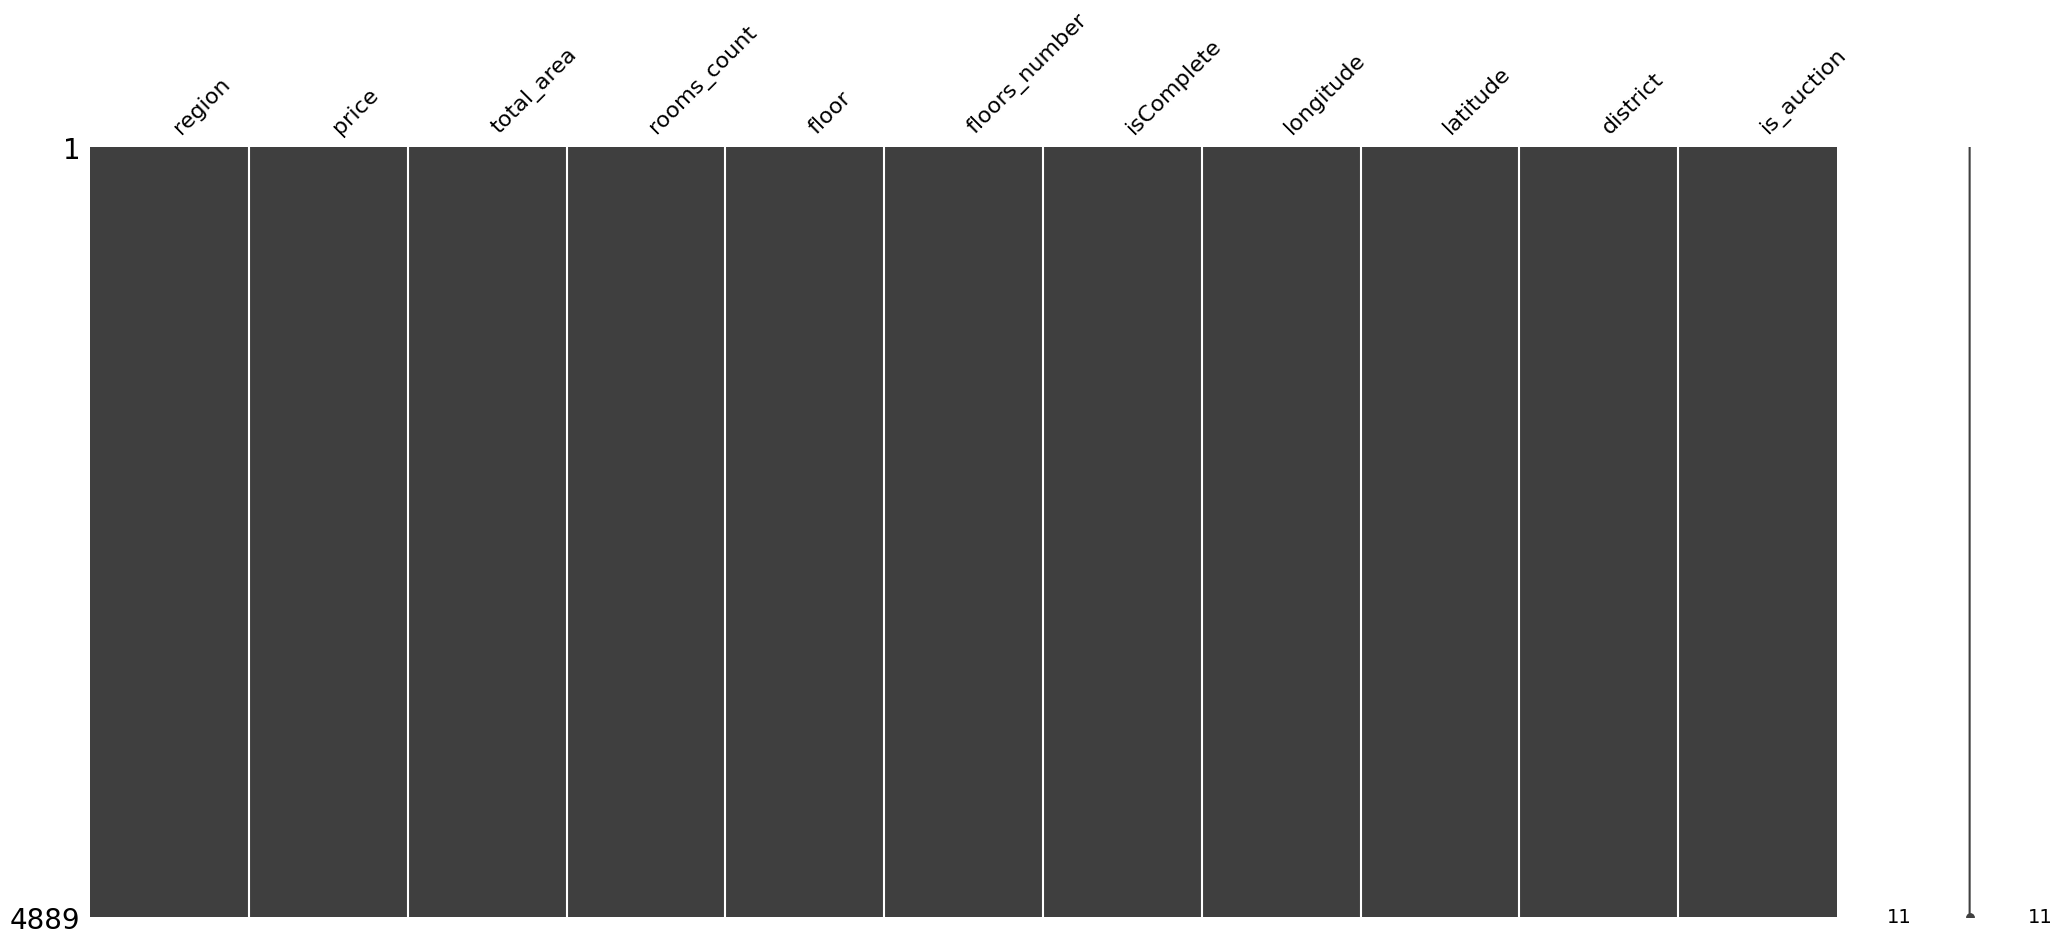

In [23]:
msno.matrix(df)
plt.show()

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'total_area'}>,
        <Axes: title={'center': 'rooms_count'}>],
       [<Axes: title={'center': 'floor'}>,
        <Axes: title={'center': 'floors_number'}>,
        <Axes: title={'center': 'isСomplete'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'is_auction'}>]], dtype=object)

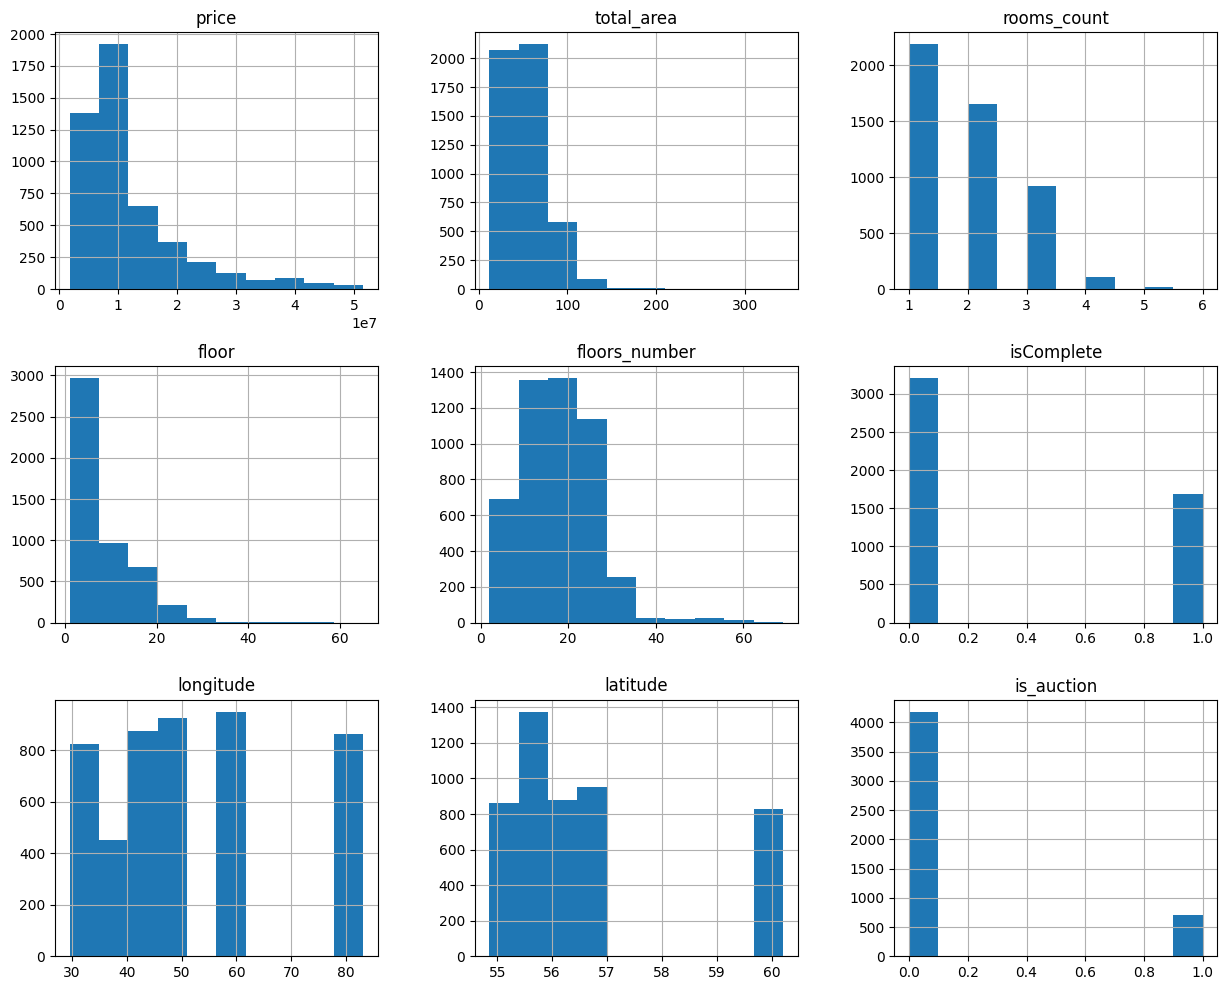

In [24]:
df.hist(figsize=(15,12))

<Axes: xlabel='longitude', ylabel='latitude'>

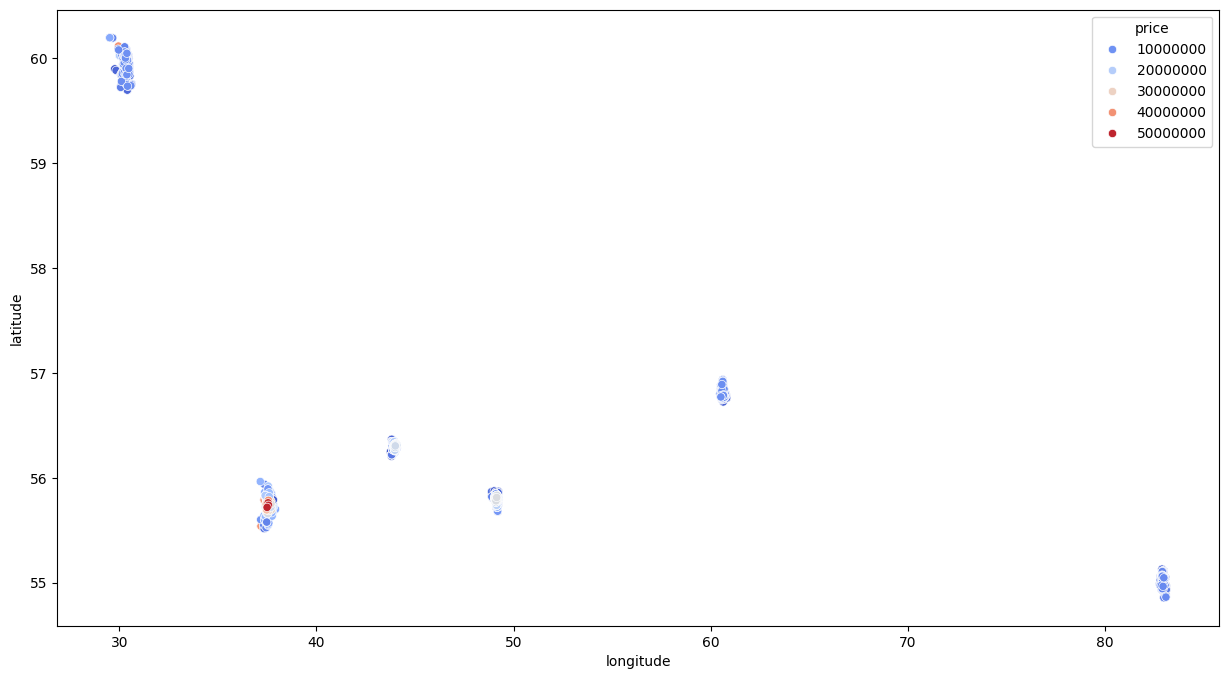

In [25]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='longitude', y='latitude', data = df, hue='price', palette='coolwarm')

In [26]:
df['region'].unique()

array(['msk', 'spb', 'ekb', 'nsk', 'kzn', 'nng'], dtype=object)

In [27]:
df = pd.get_dummies(df, columns=['region'])

<ipython-input-28-10b83f3518e0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


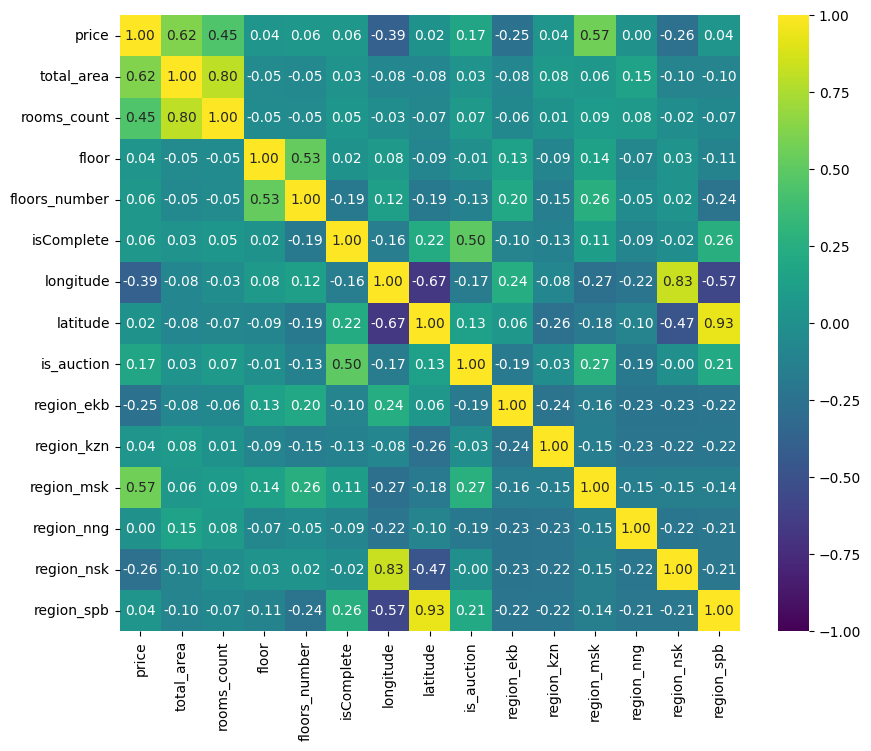

In [28]:
# Вычисление корреляционной матрицы

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='viridis', vmin=-1, vmax=1, center=0, annot=True, fmt=".2f")
plt.show()

In [29]:
df = df.drop(['district'], axis=1)

## Обучение модели

In [30]:
# Разделение данных на признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

In [31]:
# Разделение на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Инициализация и обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:
# Предсказание на тестовой выборке
predictions = model.predict(X_test)

In [34]:
# Оценка качества модели
r2 = r2_score(y_test, predictions)
print("Коэффициент детерминации (R^2):", r2)

Коэффициент детерминации (R^2): 0.7654275164646259


In [35]:
# Обучение модели Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [36]:
# Предсказание на тестовых данных
y_pred_rf = rf.predict(X_test)

In [37]:
# Оценка качества модели Random Forest
r2_rf = r2_score(y_test, y_pred_rf)
print("Коэффициент детерминации Random Forest (R^2):", r2_rf)

Коэффициент детерминации Random Forest (R^2): 0.9056673672353109


In [38]:
dump(rf, 'model_rf.joblib')

['model_rf.joblib']

## Веб-интерфейс

In [39]:
# Запускаем утилиту wget для получения внешнего IP-адреса от сервиса ipv4.icanhazip.com

!wget -q -O - ipv4.icanhazip.com

34.125.52.136


In [ ]:
# Запускает приложение streamlit (файл приложения app.py)

!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.52.136:8501

npx: installed 22 in 2.468s
your url is: https://lucky-coins-listen.loca.lt
